### Gap Junction API

In [1]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import subprocess
import torchmetrics
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    BinaryJaccardIndex
)
from torchvision.transforms.functional import to_tensor

#Custom libraries
from unet import *

#### Preprocess Data - Get Sections

In [5]:
!python3 main_processing.py \
  --preprocessing \
  --make_twoD \
  --imgs_dir "/home/tommytang111/data/sem_dauer_2/SEM_full/s110-119" \
  --seg_dir "/home/tommytang111/data/sem_dauer_2/segmentations_full/s110-119" \
  --output_dir "/home/tommytang111/data/sem_dauer_2/SEM_split/s110-119" 

Relevant Preprocessing Arguments:
Image Directory: /home/tommytang111/data/sem_dauer_2/SEM_full/s110-119
Image Template: SEM_dauer_2_em_
Segmentation Directory: /home/tommytang111/data/sem_dauer_2/segmentations_full/s110-119
Segmentation Template: sem_dauer_2_gj_gt_
Testing mode: False
Output Directory for 2d Dataset: /home/tommytang111/data/sem_dauer_2/SEM_split/s110-119
Requested Output Image Size: 512
Create Overlap: False
Segmentation Ignore: [2, 15]
NOTE: Unreported arguments were ignored.
100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


In [3]:
#Important Paths
section_of_interest = "s200-209" #Section of interest, usually 10 slices
model_dir = "/home/tommytang111/models/model5_epoch149.pk1" #Model 2d_gd_mem_run1
output_dir = Path("/home/tommytang111/inference_results/sem_adult") / section_of_interest #Output for inference
dataset_dir = Path("/home/tommytang111/data/sem_adult/SEM_split") / section_of_interest #Data

#Data and Labels (sorted because naming convention is typically dataset, section, coordinates. Example: SEM_Dauer_2_image_export_s000 -> 001)
imgs = [i for i in sorted(os.listdir(Path(dataset_dir) / "imgs"))] 
labels = [i for i in sorted(os.listdir(Path(dataset_dir) / "gts"))]

#### Load data (Either from split sections or another source)

In [4]:
#Create TestDataset class (Note:There are other dataset types in datasets.py). This defines how images/data is read from disk.
dataset = TestDataset(dataset_dir, td=False, membrane=False)
#Load dataset class in Dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

#### Load model

In [5]:
model = joblib.load(model_dir)
model = model.to("cuda") #Send to gpu
model.eval() #Set evaluation mode

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

#### Inference

In [6]:
"""
Generates gap junction prediction masks for each batch, converting each tensor into a numpy array with cpu as uint8. 
Keeps track of the image number while going through batches, assuming the data is sorted by alphabetically ascending 
order when read from disk. 
"""

img_num = 0 #References which image is being refered to in imgs:List

with torch.no_grad(): 
    for batch in tqdm(dataloader):
        image = batch[0].to("cuda")
        batch_pred = model(image)
        for i in range(batch_pred.shape[0]): #For each image in the batch
            #Convert tensor to binary mask using Sigmoid activation first
            gj_pred = (nn.Sigmoid()(batch_pred[i]) >= 0.5)
            gj_pred = gj_pred.squeeze(0).detach().cpu().numpy().astype("uint8")
            save_name = Path(output_dir) / re.sub(r'.png$', r'_pred.png', imgs[img_num])
            cv2.imwrite(save_name, gj_pred * 255) #All values either black:0 or white:255
            img_num += 1

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


#### Visualize Results

Text(0.5, 1.0, 'Overlay')

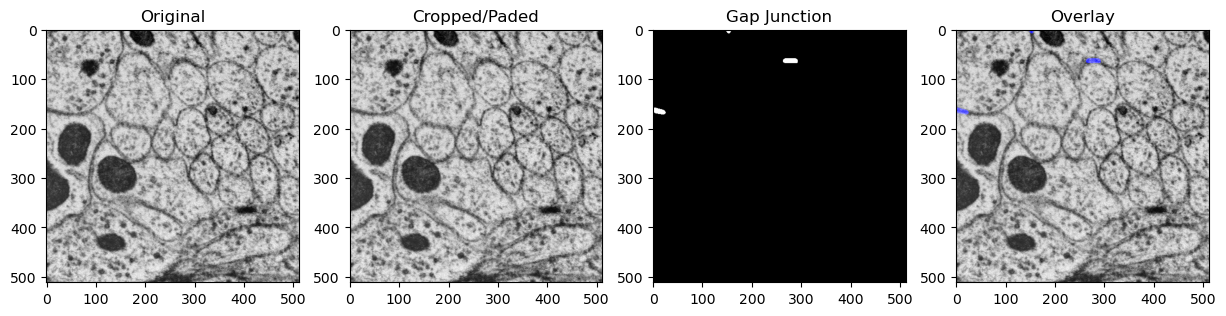

In [7]:
#Test a random image from the dataset
random_path = random.choice(imgs)
random_img = Path(dataset_dir) / "imgs" / random_path
random_resized_img = np.array(resize_image(str(random_img), 512, 512, (0,0,0)))
random_pred = cv2.imread(str(Path(output_dir) / re.sub(r'.png$', r'_pred.png', str(random_path))), cv2.IMREAD_GRAYSCALE)

#Make overlay
random_pred2 = cv2.cvtColor(random_pred, cv2.COLOR_GRAY2RGB)
random_pred2[random_pred == 255] = [0, 0, 255] #Blue
overlay = cv2.addWeighted(random_resized_img, 1, random_pred2, 1, 0)

#Plot
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(cv2.imread(random_img), cmap="gray")
ax[0].set_title('Original')
ax[1].imshow(random_resized_img, cmap="gray")
ax[1].set_title('Cropped/Paded')
ax[2].imshow(random_pred, cmap="gray")
ax[2].set_title('Gap Junction')
ax[3].imshow(overlay)
ax[3].set_title('Overlay')

#### Post-Inference Evaluation

In [17]:
#Create results dictionary
results = {'accuracy': [],
           'precision': [],
           'recall': [],
           'f1': [],
           'iou': [],
           'dice': []
}

#### Method 1: GPU (2X Faster)

In [15]:
# Initialize metrics on GPU for speed
device = torch.device('cuda')
metrics = {
    'accuracy': BinaryAccuracy().to(device),
    'precision': BinaryPrecision().to(device),
    'recall': BinaryRecall().to(device),
    'f1': BinaryF1Score().to(device),
    'iou': BinaryJaccardIndex().to(device)
}

all_preds = []
all_labels = []

# First collect all predictions and labels
for img in tqdm(imgs):
    # Load prediction
    gj_pred = Path(output_dir) / re.sub(r'.png$', r'_pred.png', img)
    gj_pred = cv2.imread(str(gj_pred), cv2.IMREAD_GRAYSCALE)
    
    # Load label
    label = Path(dataset_dir) / "gts" / re.sub(r'.png$', r'_label.png', img)
    label = cv2.imread(str(label), cv2.IMREAD_GRAYSCALE)
    label[label != 0] = 255  # Convert 1s to 255 if they aren't already 255
    
    # Ensure same dimensions
    if gj_pred.shape != label.shape:
        gj_pred = cv2.resize(gj_pred, (label.shape[1], label.shape[0]))
    
    # Binarize
    gj_pred_binary = (gj_pred > 127).astype(np.uint8)
    label_binary = (label > 128).astype(np.uint8)
    
    # Convert to tensors
    gj_pred_tensor = torch.from_numpy(gj_pred_binary).float()
    label_tensor = torch.from_numpy(label_binary).float()
    
    all_preds.append(gj_pred_tensor)
    all_labels.append(label_tensor)

with torch.no_grad():
    # Stack all images into a single batch if they're the same size
    if all(p.shape == all_preds[0].shape for p in all_preds):
        pred_batch = torch.stack(all_preds).to(device)
        label_batch = torch.stack(all_labels).to(device)
        
        # Calculate metrics in one go
        for metric_name, metric_fn in metrics.items():
            results[metric_name] = metric_fn(pred_batch, label_batch).item()
        
        # Calculate Dice score from IoU (they're related)
        results['dice'] = 2 * results['iou'] / (1 + results['iou'])
    else:
        # If images have different sizes, process one by one but still use GPU
        for metric_name, metric_fn in metrics.items():
            metric_fn.reset()
            
        for pred, label in zip(all_preds, all_labels):
            pred = pred.unsqueeze(0).to(device)  # Add batch dimension
            label = label.unsqueeze(0).to(device)
            
            for metric_name, metric_fn in metrics.items():
                metric_fn.update(pred, label)
        
        # Compute final metrics
        for metric_name, metric_fn in metrics.items():
            results[metric_name] = metric_fn.compute().item()
        
        # Calculate Dice score
        results['dice'] = 2 * results['iou'] / (1 + results['iou'])

# Print results
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 327.51it/s]


accuracy: 0.9630
precision: 0.5275
recall: 0.0381
f1: 0.0711
iou: 0.0369
dice: 0.0711


#### Method 2: CPU (default)

In [18]:
#We have a list of all the input image file names in imgs
for img in tqdm(imgs):
    #Load Predictions
    gj_pred = Path(output_dir) / re.sub(r'.png$', r'_pred.png', img)
    gj_pred = cv2.imread(gj_pred, cv2.IMREAD_GRAYSCALE)

    #Load Labels
    label = Path(dataset_dir) / 'gts' / re.sub(r'.png$', r'_label.png', img)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)
    label[label != 0] = 255  # Convert 1s to 255 if they aren't already 255
    
    #Ensure same dimensions
    if gj_pred.shape != label.shape:
        gj_pred = cv2.resize(gj_pred, (gj_pred.shape[1], gj_pred.shape[0]))
        
    #Binarize masks (0 or 1)
    gj_pred_binary = (gj_pred > 127).astype(np.uint8)
    label_binary = (label > 128).astype(np.uint8)
    
    #Flatten masks for metric calculations
    gj_pred_flat = gj_pred_binary.flatten()
    label_flat = label_binary.flatten()
    
    #Calculate metrics
    cm = confusion_matrix(label_flat, gj_pred_flat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel() #Extract from confusion matrix
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    dice = (2 * iou) / (1 + iou)
    
    #Append to results
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['iou'].append(iou)
    results['dice'].append(dice)

    """Another way but slower
    results['accuracy'].append(accuracy_score(label_flat, gj_pred_flat))
    results['precision'].append(precision_score(label_flat, gj_pred_flat, zero_division=0))
    results['recall'].append(recall_score(label_flat, gj_pred_flat, zero_division=0))
    results['f1'].append(f1_score(label_flat, gj_pred_flat, zero_division=0))
    results['iou'].append(jaccard_score(label_flat, gj_pred_flat, zero_division=0))
    
    #Calculate Dice Manually
    intersection = np.logical_and(gj_pred_binary, label_binary).sum()
    dice = (2.0 * intersection) / (gj_pred_binary.sum() + label_binary.sum() + 1e-10)
    results['dice'].append(dice)"""
    
#Calculate averages
for key in results:
    results[key] = np.mean(results[key])

print(results)

100%|██████████| 40/40 [00:00<00:00, 83.06it/s]

{'accuracy': np.float64(0.9630414962768554), 'precision': np.float64(0.4524499383511638), 'recall': np.float64(0.04390179992924966), 'f1': np.float64(0.07216587454443892), 'iou': np.float64(0.03965899235727431), 'dice': np.float64(0.07216587564669431)}


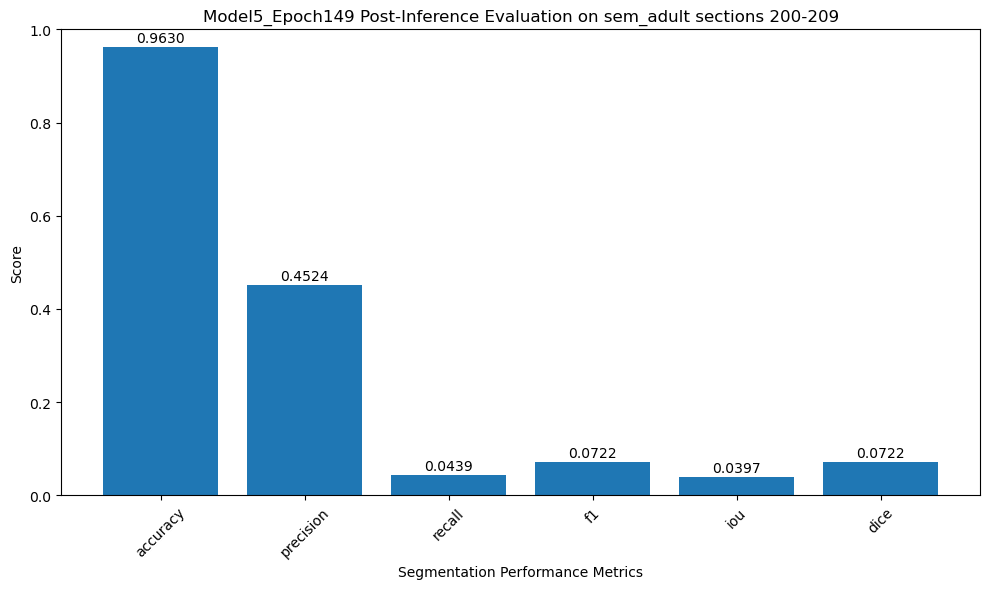

In [19]:
#Plot bar chart of evaluation results
plt.figure(figsize=(10,6))
plt.title('Model5_Epoch149 Post-Inference Evaluation on sem_adult sections 200-209')
plt.bar(results.keys(), results.values())
plt.ylim(0,1)
plt.xlabel('Segmentation Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


#### Stitching

In [40]:
!python3 main_processing.py \
  --postprocessing \
  --imgs_dir "/mnt/e/Mishaal/sem_dauer_2/image_export" \
  --preds_dir "/home/tommytang111/results" \
  --output_dir "/home/tommytang111/assembled_results" \
  --img_template SEM_dauer_2_image_export_ \
  --seg_template SEM_dauer_2_image_export_ \
  --Smin 0 --Smax 51 \
  --Ymin 0 --Ymax 17 \
  --Xmin 0 --Xmax 19 \
  --offset 0

Relevant Postprocessing Arguments:
Image Directory: /mnt/e/Mishaal/sem_dauer_2/image_export
Segmentation Directory: 
Prediction Directory: /home/tommytang111/results
Output Directory: /home/tommytang111/assembled_results
Print legend: False
Missing Directory: None
Image Template: SEM_dauer_2_image_export_
Segmentation Template: SEM_dauer_2_image_export_
Smin: 0 Smx: 51
Xmin: 0 Xmax: 19
Ymin: 0 Ymax: 17
Offset: 0
Note: Unreported arguments were ignored.
  0%|                                                    | 0/17 [00:00<?, ?it/s][ WARN:0@0.723] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_dauer_2_image_export_s000_Y0_X0_pred.png'): can't open/read file: check file path/integrity

[ WARN:0@0.745] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_dauer_2_image_export_s000_Y0_X1_pred.png'): can't open/read file: check file path/integrity

[ WARN:0@0.771] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_d

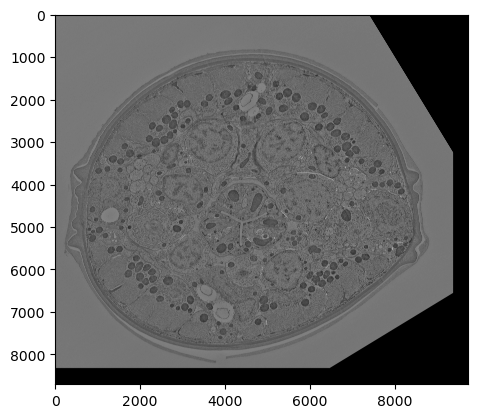

In [39]:
#Visualize stitching
b = cv2.imread("/home/tommytang111/assembled_results/SEM_dauer_2_image_export_s000_img.png", cv2.IMREAD_GRAYSCALE)
a = cv2.imread("/home/tommytang111/assembled_results/SEM_dauer_2_image_export_s000_pred.png", cv2.IMREAD_GRAYSCALE)
plt.figure(1)
plt.imshow(b, cmap="gray")
plt.imshow(a, cmap="gray", alpha=0.4)
plt.savefig("/home/tommytang111/outputs/SEM_dauer_2_image_export_s000_overlay.png", dpi=1500)
#np.any(a != 0)

#### Miscellaneous

In [ ]:
#Renaming label files to match the image file convention
#Original name = sem2dauer_gj_2d_training.vsseg_export_s000_Y4_X5.png.png
#Target name = SEM_dauer_2_image_export_s000_Y4_X5_label.png.png
!rename 's/^(sem2dauer_gj_2d_training.vsseg_export_\w+)\.png\.png$/SEM_dauer_2_image_export_$1_label.png.png/' sem2dauer_gj_2d_training.vsseg_export_*.png.png

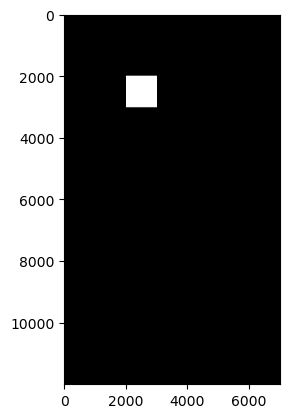

In [ ]:
#Make a mask for VAST
from PIL import Image
a = Image.new('RGB', (7000, 12000), (0,0,0))
b = Image.new('RGB', (1024, 1024), (512, 512, 512))
a.paste(b, (2000, 2000))
plt.imshow(a)
a.save("test.png")


In [ ]:
#Want to visualize logits of the model
c = batch_pred[0].cpu().squeeze(0).numpy()

In [ ]:
#Confirm gts are 0 or 255
import glob
d = cv2.imread(random.choice(glob.glob("/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/gts/*.png")), cv2.IMREAD_GRAYSCALE)